# Possible customer satisfaction scores producing an NPS score

Given a single NPS score, demonstrate the range of possible customer satisfaction scores that could have resulted in that score. The approach treats the problem like recovering inputs to a lossy process, or perhaps a cryptarithmetic puzzle, using OR tools.

## Setup

In [1]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from scipy import stats

In [3]:
class SolutionDataFrame(cp_model.CpSolverSolutionCallback):

    def __init__(self, df, variables, max_solution_count):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.df = df
        self.max_solution_count = max_solution_count
        self.variables = variables
        self.solution_count = 0

    def on_solution_callback(self):
        self.df.loc[self.solution_count] = [self.Value(v) for v in self.variables]
        self.solution_count += 1
        if self.solution_count >= self.max_solution_count:
          self.StopSearch()


## Define the CP SAT model

In [4]:
def nps_model(nps_score, response_count):

  # the model and response enumeration
  model = cp_model.CpModel()
  responses = list(range(response_count))

  # categories of responses
  promoters = [model.NewBoolVar(f'p_{r + 1}') for r in responses]
  neutrals = [model.NewBoolVar(f'n_{r + 1}') for r in responses]
  detractors = [model.NewBoolVar(f'd_{r + 1}') for r in responses]

  # ensure the ratio of categories produces the NPS score
  model.Add((sum(promoters) - sum(detractors)) * 100 == response_count * nps_score)
  
  # ensure every response is in one category
  for r in responses:
    model.Add(promoters[r] + neutrals[r] + detractors[r] == 1)

  # individual sat score responses
  sat_scores = [model.NewIntVar(0, 10, f'sat_{r + 1}') for r in responses]

  # limit possible sat scores based on the category
  for r in responses:
    model.Add(sat_scores[r] >= 9).OnlyEnforceIf(promoters[r])
    model.Add(sat_scores[r] <= 8).OnlyEnforceIf(neutrals[r])
    model.Add(sat_scores[r] >= 7).OnlyEnforceIf(neutrals[r])
    model.Add(sat_scores[r] <= 6).OnlyEnforceIf(detractors[r])

  # ensure responses are sorted to avoid duplicated solutions
  for p in zip(sat_scores[:-1], sat_scores[1:]):
    model.Add(p[1] >= p[0])

  return model, sat_scores

## Collect possible solutions

In [5]:
def solution_df(model, sat_scores, max_solution_count):
  solver = cp_model.CpSolver()
  df = pd.DataFrame(columns=[str(s) for s in sat_scores])
  solution_accumulator = SolutionDataFrame(df, sat_scores, max_solution_count)
  solver.parameters.enumerate_all_solutions = True
  status = solver.Solve(model, solution_accumulator)
  return df, status

## Explore one scenario

In [6]:
def visualise_solution(df, ax):
  marker = itertools.cycle(('x', '+', 'o', '^', '*'))
  for i in df.index:
    ax.plot(df.columns, df.loc[i], linestyle='none', marker=next(marker), markerfacecolor='none')
  ax.plot([df.columns[0], df.columns[-1]], [6.5, 6.5], '--', color='lightgrey')
  ax.plot([df.columns[0], df.columns[-1]], [8.5, 8.5], '--', color='lightgrey')
  ax.set_ylim(-1, 11)
  ax.set_yticks(range(0, 11))
  ax.legend(df.index, loc='lower right')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

In [7]:
nps_1 = 40
model, sat_scores = nps_model(nps_1, 10)
df_1, _ = solution_df(model, sat_scores, 5000)

In [8]:
print(len(df_1.index))
df_1.head()

1505


,sat_1,sat_2,sat_3,sat_4,sat_5,sat_6,sat_7,sat_8,sat_9,sat_10
0,0,7,7,7,7,9,9,9,9,9
1,0,7,7,7,7,9,9,9,9,10
2,0,7,7,7,7,9,9,9,10,10
3,0,7,7,7,7,9,9,10,10,10
4,0,7,7,7,7,9,10,10,10,10


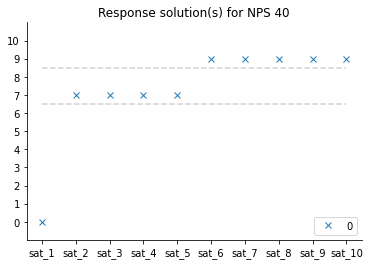

In [9]:
visualise_solution(df_1.iloc[0:1], plt.gca())
plt.title(f'Response solution(s) for NPS {nps_1}')
plt.show()

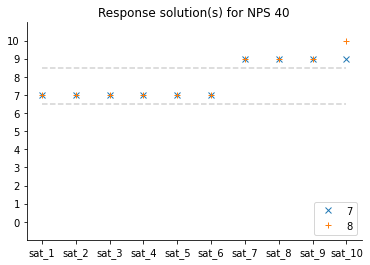

In [10]:
visualise_solution(df_1[df_1['sat_1'] >= 7].iloc[0:2], plt.gca())
plt.title(f'Response solution(s) for NPS {nps_1}')
plt.show()

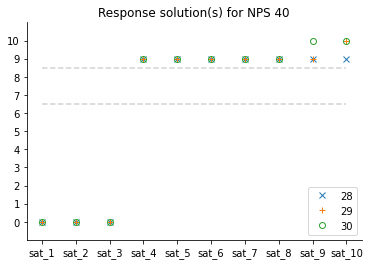

In [11]:
visualise_solution(df_1[df_1['sat_3'] <= 6].iloc[0:3], plt.gca())
plt.title(f'Response solution(s) for NPS {nps_1}')
plt.show()

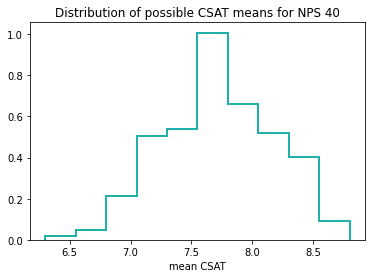

In [12]:
mean_1 = df_1.transpose().mean()
plt.hist(mean_1, density=True, histtype='step', lw=2, color='lightseagreen')
plt.title(f'Distribution of possible CSAT means for NPS {nps_1}')
plt.xlabel('mean CSAT')
plt.show()

## Explore the whole range of NPS

calculating nps -100
calculating nps -90
calculating nps -80
calculating nps -70
calculating nps -60
calculating nps -50
calculating nps -40
calculating nps -30
calculating nps -20
calculating nps -10
calculating nps 0
calculating nps 10
calculating nps 20
calculating nps 30
calculating nps 40
calculating nps 50
calculating nps 60
calculating nps 70
calculating nps 80
calculating nps 90
calculating nps 100


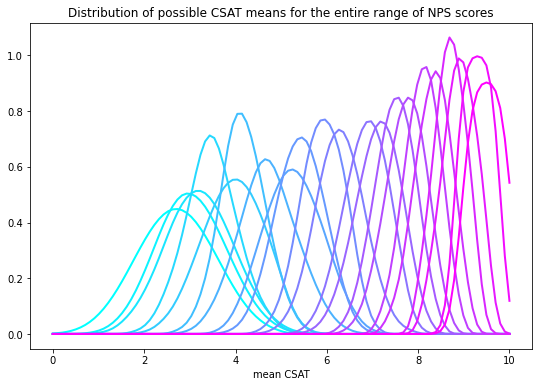

In [13]:
cmap = matplotlib.cm.get_cmap('cool')

plt.figure(figsize=(9,6))
for n in range(-100, 110, 10):
  print(f'calculating nps {n}')
  model, sat_scores = nps_model(n, 10)
  df, _ = solution_df(model, sat_scores, 5000)
  mean = df.transpose().mean()
  t = (n - -100) / 200

  kde = stats.gaussian_kde(mean)
  xx = np.linspace(0, 10, 100)
  plt.plot(xx, kde(xx), lw=2, color=cmap(t))

plt.title('Distribution of possible CSAT means for the entire range of NPS scores')
plt.xlabel('mean CSAT')
plt.show()